In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
import json
import time

In [108]:
from pprint import pprint as pp

In [2]:
bus_odn = pd.read_csv('data/origin_destination_bus_202208.csv')
bus_odn.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,ORIGIN_PT_CODE,DESTINATION_PT_CODE,TOTAL_TRIPS
0,2022-08,WEEKENDS/HOLIDAY,17,BUS,24499,22221,2
1,2022-08,WEEKENDS/HOLIDAY,10,BUS,65239,65159,2
2,2022-08,WEEKDAY,10,BUS,65239,65159,2
3,2022-08,WEEKDAY,7,BUS,23519,23311,1
4,2022-08,WEEKDAY,16,BUS,54349,53241,1


In [3]:
bus_odn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145481 entries, 0 to 5145480
Data columns (total 7 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   YEAR_MONTH           object
 1   DAY_TYPE             object
 2   TIME_PER_HOUR        int64 
 3   PT_TYPE              object
 4   ORIGIN_PT_CODE       int64 
 5   DESTINATION_PT_CODE  int64 
 6   TOTAL_TRIPS          int64 
dtypes: int64(4), object(3)
memory usage: 274.8+ MB


In [4]:
bus_odn[(bus_odn['ORIGIN_PT_CODE']==24499) & (bus_odn['DESTINATION_PT_CODE']==22221)]

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,ORIGIN_PT_CODE,DESTINATION_PT_CODE,TOTAL_TRIPS
0,2022-08,WEEKENDS/HOLIDAY,17,BUS,24499,22221,2
429423,2022-08,WEEKDAY,11,BUS,24499,22221,1
429424,2022-08,WEEKENDS/HOLIDAY,11,BUS,24499,22221,1
990596,2022-08,WEEKDAY,18,BUS,24499,22221,1
2295062,2022-08,WEEKENDS/HOLIDAY,19,BUS,24499,22221,1
3937341,2022-08,WEEKENDS/HOLIDAY,16,BUS,24499,22221,1
5056726,2022-08,WEEKENDS/HOLIDAY,21,BUS,24499,22221,1


In [5]:
def get_peak_status(hour):
    if hour<9:
        return 'AM_Peak_Freq'
    elif hour<17:
        return 'AM_Offpeak_Freq'
    elif hour<19:
        return 'PM_Peak_Freq'
    else:
        return 'PM_Offpeak_Freq'

In [6]:
bus_odn['freq_type'] = bus_odn.apply(lambda x: get_peak_status(x['TIME_PER_HOUR']), axis=1)
bus_odn

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,ORIGIN_PT_CODE,DESTINATION_PT_CODE,TOTAL_TRIPS,freq_type
0,2022-08,WEEKENDS/HOLIDAY,17,BUS,24499,22221,2,PM_Peak_Freq
1,2022-08,WEEKENDS/HOLIDAY,10,BUS,65239,65159,2,AM_Offpeak_Freq
2,2022-08,WEEKDAY,10,BUS,65239,65159,2,AM_Offpeak_Freq
3,2022-08,WEEKDAY,7,BUS,23519,23311,1,AM_Peak_Freq
4,2022-08,WEEKDAY,16,BUS,54349,53241,1,AM_Offpeak_Freq
...,...,...,...,...,...,...,...,...
5145476,2022-08,WEEKDAY,11,BUS,5131,14271,10,AM_Offpeak_Freq
5145477,2022-08,WEEKENDS/HOLIDAY,11,BUS,5131,14271,5,AM_Offpeak_Freq
5145478,2022-08,WEEKDAY,16,BUS,47811,54009,2,AM_Offpeak_Freq
5145479,2022-08,WEEKDAY,17,BUS,67259,59031,15,PM_Peak_Freq


In [9]:
temp = bus_odn.groupby(['ORIGIN_PT_CODE','DESTINATION_PT_CODE', 'freq_type', 'DAY_TYPE'])['TOTAL_TRIPS'].sum().to_frame(name='avg_trips').reset_index()
temp.head()

,ORIGIN_PT_CODE,DESTINATION_PT_CODE,freq_type,DAY_TYPE,avg_trips
0,1012,1112,AM_Offpeak_Freq,WEEKDAY,927
1,1012,1112,AM_Offpeak_Freq,WEEKENDS/HOLIDAY,344
2,1012,1112,AM_Peak_Freq,WEEKDAY,161
3,1012,1112,AM_Peak_Freq,WEEKENDS/HOLIDAY,39
4,1012,1112,PM_Offpeak_Freq,WEEKDAY,213


In [11]:
def weighted_avg_trips(df):
    avg = 0
    if len(df) > 2:
        print("ERROR")
        print(df)
        print()
    # not all services run on all days so use this
    for i, row in df.iterrows():
        if row['DAY_TYPE'] == "WEEKENDS/HOLIDAY":
            avg += row['avg_trips']*2/7
        else:
            avg += row['avg_trips']*5/7
    return avg

In [14]:
%%time
final_bus_odn = temp.groupby(['ORIGIN_PT_CODE','DESTINATION_PT_CODE', 'freq_type']).apply(weighted_avg_trips).to_frame(name='avg_trips').reset_index()
final_bus_odn

Wall time: 2min 35s


,ORIGIN_PT_CODE,DESTINATION_PT_CODE,freq_type,avg_trips
0,1012,1112,AM_Offpeak_Freq,760.428571
1,1012,1112,AM_Peak_Freq,126.142857
2,1012,1112,PM_Offpeak_Freq,175.285714
3,1012,1112,PM_Peak_Freq,245.857143
4,1012,1113,AM_Offpeak_Freq,438.142857
...,...,...,...,...
1010735,99189,99039,AM_Peak_Freq,0.714286
1010736,99189,99039,PM_Peak_Freq,8.571429
1010737,99189,99049,AM_Offpeak_Freq,17.285714
1010738,99189,99049,PM_Offpeak_Freq,5.000000


In [15]:
final_bus_odn.rename(columns={'ORIGIN_PT_CODE':'orig', 'DESTINATION_PT_CODE':'dest'}, inplace=True)
final_bus_odn

,orig,dest,freq_type,avg_trips
0,1012,1112,AM_Offpeak_Freq,760.428571
1,1012,1112,AM_Peak_Freq,126.142857
2,1012,1112,PM_Offpeak_Freq,175.285714
3,1012,1112,PM_Peak_Freq,245.857143
4,1012,1113,AM_Offpeak_Freq,438.142857
...,...,...,...,...
1010735,99189,99039,AM_Peak_Freq,0.714286
1010736,99189,99039,PM_Peak_Freq,8.571429
1010737,99189,99049,AM_Offpeak_Freq,17.285714
1010738,99189,99049,PM_Offpeak_Freq,5.000000


In [16]:
final_bus_odn.to_csv('data/bus_odn.csv', index=False)

In [17]:
with open('data/service_no_dict.json', 'r') as fileobj:
    full_bus_info = json.load(fileobj)

In [20]:
len(full_bus_info)

534

In [18]:
full_bus_info['10']

{'busstop': ['75009',
  '76059',
  '76069',
  '96289',
  '96109',
  '85079',
  '85089',
  '85069',
  '85059',
  '85049',
  '85039',
  '85029',
  '85019',
  '94079',
  '94069',
  '94059',
  '94049',
  '94089',
  '94039',
  '94029',
  '94019',
  '93099',
  '93089',
  '93079',
  '93069',
  '93059',
  '92159',
  '92149',
  '92139',
  '92129',
  '92119',
  '92109',
  '92099',
  '92161',
  '82071',
  '81199',
  '81189',
  '81179',
  '80141',
  '80219',
  '80169',
  '80159',
  '02119',
  '03019',
  '03059',
  '03129',
  '03217',
  '05649',
  '14061',
  '14071',
  '14081',
  '14101',
  '14141',
  '14121',
  '14131',
  '14151',
  '14161',
  '14171',
  '15141',
  '15151',
  '15161',
  '15191',
  '15201',
  '15221',
  '16201',
  '16011',
  '16021',
  '16031',
  '16041',
  '16051',
  '16061',
  '16071',
  '16081',
  '16009',
  '16009',
  '16089',
  '16079',
  '16069',
  '16059',
  '16049',
  '16039',
  '16029',
  '16019',
  '16209',
  '15229',
  '15219',
  '15209',
  '15199',
  '15169',
  '15159',

In [32]:
bus_dist_dict = {k:{int(v['busstop'][i]):(v['initial_dist'][i], i) for i in range(len(v['busstop'])-1)} for k, v in full_bus_info.items()}
bus_dist_dict['10']

{75009: (0, 0),
 76059: (0.6, 1),
 76069: (1.1, 2),
 96289: (2.3, 3),
 96109: (2.7, 4),
 85079: (3.3, 5),
 85089: (3.5, 6),
 85069: (3.8, 7),
 85059: (4.1, 8),
 85049: (4.5, 9),
 85039: (4.8, 10),
 85029: (5, 11),
 85019: (5.2, 12),
 94079: (5.5, 13),
 94069: (6.1, 14),
 94059: (6.4, 15),
 94049: (6.8, 16),
 94089: (7, 17),
 94039: (7.3, 18),
 94029: (7.7, 19),
 94019: (7.9, 20),
 93099: (8.3, 21),
 93089: (8.8, 22),
 93079: (9.1, 23),
 93069: (9.4, 24),
 93059: (9.8, 25),
 92159: (10.1, 26),
 92149: (10.4, 27),
 92139: (10.7, 28),
 92129: (11.2, 29),
 92119: (11.7, 30),
 92109: (11.9, 31),
 92099: (12.2, 32),
 92161: (12.7, 33),
 82071: (13.1, 34),
 81199: (13.9, 35),
 81189: (14.2, 36),
 81179: (14.7, 37),
 80141: (15.3, 38),
 80219: (16, 39),
 80169: (17.4, 40),
 80159: (18.1, 41),
 2119: (18.6, 42),
 3019: (19.6, 43),
 3059: (19.9, 44),
 3129: (20.3, 45),
 3217: (20.6, 46),
 5649: (21.5, 47),
 14061: (21.8, 48),
 14071: (22.3, 49),
 14081: (22.7, 50),
 14101: (23.1, 51),
 14141: (2

In [28]:
bus_freq_dict = {k:{i:v[i] for i in ['AM_Peak_Freq', 'AM_Offpeak_Freq', 'PM_Peak_Freq', 'PM_Offpeak_Freq']} for k, v in full_bus_info.items()}
bus_freq_dict['10']

{'AM_Peak_Freq': 10.5,
 'AM_Offpeak_Freq': 13.5,
 'PM_Peak_Freq': 10.5,
 'PM_Offpeak_Freq': 14.5}

In [34]:
for k, v in bus_freq_dict.items():
    for i in v.values():
        if i is None:
            print(k)

100A
105B
105B
105B
106A
106A
109A
109A
10e
10e
10e
112A
112A
112A
113A
114A
114A
114A
116A
116A
116A
117
117A
117A
117A
117M
117M
118A
118A
118A
118B
118B
118B
125A
125A
125A
127A
127A
127A
12e
130A
131A
131A
131A
137A
137A
137A
138A
138A
138A
138B
138B
13A
13A
142A
142A
142A
142A
145A
145A
147A
147A
14A
14A
14e
14e
14e
154A
154A
154A
154B
154B
154B
158A
158A
158A
159A
159A
159B
159B
159B
15A
15A
15A
163A
163A
163A
169A
169A
169A
169B
169B
169B
16M
16M
16M
173A
173A
173A
174e
174e
174e
177
178A
178A
178A
179A
179A
180A
180A
181M
181M
181M
182
182M
183B
183B
188e
188e
188e
189A
190A
190A
190A
195A
195A
195A
196A
196A
196A
196A
196e
196e
196e
198A
198A
200A
200A
200A
200A
21A
21A
21A
222A
222A
222A
222B
240A
240A
240A
240M
240M
241A
241A
248
248
268A
268A
268A
268B
268B
268C
268C
269A
27A
27A
29A
29A
2A
2A
302A
302A
30e
30e
30e
31A
31A
33A
33A
33A
33B
33B
33B
34A
34A
34B
34B
34B
34B
35M
35M
35M
36A
36A
36A
36A
36B
382A
382A
382A
401
405
405
43e
43e
45A
45A
45A
502A
502A
502A
513
513
513

In [35]:
bus_freq_dict['100A']

{'AM_Peak_Freq': 31.0,
 'AM_Offpeak_Freq': None,
 'PM_Peak_Freq': 23.5,
 'PM_Offpeak_Freq': 17.0}

In [61]:
def custom_mean(arr):
    # required because numpy mean is a pain with None/NaN values
    m = 0
    c = 0
    for i in arr:
        if not pd.isna(i):
            m += i
            c += 1
    if m==0:
        return 0
    else:
        return m/c

In [57]:
custom_mean(bus_freq_dict['100A'].values())

23.833333333333332

In [62]:
custom_mean([custom_mean(v.values()) for v in bus_freq_dict.values()])  # used for imputing when all values missing

13.600421348314608

In [153]:
def get_fastest_bus(orig, dest, freq_type):
    bus_speed = 20  # assuming 20kmph based on some googling
    bus_candidates = {}
    for k, v in bus_dist_dict.items():
        if orig in v and dest in v:
            total_stops, max_dist = len(v), max([i[0] for i in v.values()])
            dist = v[dest][0]-v[orig][0]
            num_stops = v[dest][1]-v[orig][1] - 1  # number of in-between stops
#             print(v[dest], v[orig])
            if num_stops<0:
                # went through two "ends" of a loop
                dist = 2*max_dist + dist
                num_stops = total_stops + num_stops
            elif (v[dest][1]>total_stops//2 and v[orig][1]<=total_stops//2) or (num_stops>=0 and dist<0):
                # went through one "end" of a loop
                dist = max_dist + dist
            if dist<0:
                print(orig, dest, k, dist, num_stops)
            temp_travel_time = dist/bus_speed * 3600 + 10 * num_stops  # adding 10s at each stop
            temp_freq = bus_freq_dict[k][freq_type]
            if temp_freq is None:
                temp_freq = custom_mean([j for j in bus_freq_dict['100A'].values()])
            if temp_freq==0:
                temp_freq = 13.6  # global average
            temp_wait_time = temp_freq/2 * 60  # assuming half the wait-time as avg
            
            bus_candidates[k] = {'travel':temp_travel_time, 'wait':temp_wait_time, 'total':temp_travel_time+temp_wait_time, 'num_stops': num_stops}
    
    if len(bus_candidates):
        best_bus = min(bus_candidates, key=lambda k: bus_candidates[k]['total'])
        parallel_buses = {k:v for k,v in bus_candidates.items() if v['num_stops']<=bus_candidates[best_bus]['num_stops']}
        try:
            real_total_time = 1/sum([1/i['total'] for i in parallel_buses.values()])  # accounts for multiple buses along the same path
        except ZeroDivisionError:
            # stops must be the same???
            print(f"Zero dist between {orig} and {dest}:\n{bus_candidates}\n\n")
            real_total_time = 0
        return set(parallel_buses.keys()), real_total_time, bus_candidates
    else:
        print(f"Impossible route between {orig} and {dest}")
        return set(), None, dict()

In [92]:
%%time
get_fastest_bus(1012, 1113, 'PM_Peak_Freq')

Wall time: 999 µs


({'2', '2A', '32', '33', '51', '61'},
 82.48652993018774,
 {'2': {'travel': 108.0000000000001,
   'wait': 285.0,
   'total': 393.0000000000001,
   'num_stops': 0},
  '2A': {'travel': 108.0000000000001,
   'wait': 1080.0,
   'total': 1188.0,
   'num_stops': 0},
  '32': {'travel': 108.00000000000026,
   'wait': 375.0,
   'total': 483.0000000000002,
   'num_stops': 0},
  '33': {'travel': 107.99999999999993,
   'wait': 300.0,
   'total': 407.99999999999994,
   'num_stops': 0},
  '51': {'travel': 108.00000000000026,
   'wait': 390.0,
   'total': 498.0000000000002,
   'num_stops': 0},
  '61': {'travel': 107.99999999999962,
   'wait': 345.0,
   'total': 452.9999999999996,
   'num_stops': 0}})

In [93]:
get_fastest_bus(16009, 15229, 'PM_Peak_Freq')

({'10', '200'},
 476.2204724409449,
 {'10': {'travel': 630.0, 'wait': 315.0, 'total': 945.0, 'num_stops': 9},
  '200': {'travel': 630.0, 'wait': 330.0, 'total': 960.0, 'num_stops': 9}})

In [94]:
get_fastest_bus(75009, 16009, 'PM_Peak_Freq')  # two ends of the loop for '10'

({'10'},
 1045.0,
 {'10': {'travel': 730.0, 'wait': 315.0, 'total': 1045.0, 'num_stops': 73}})

In [66]:
bus_odn_dict = final_bus_odn.to_dict('records')  # for speed-up
bus_odn_dict[:5]

[{'orig': 1012,
  'dest': 1112,
  'freq_type': 'AM_Offpeak_Freq',
  'avg_trips': 760.4285714285714},
 {'orig': 1012,
  'dest': 1112,
  'freq_type': 'AM_Peak_Freq',
  'avg_trips': 126.14285714285714},
 {'orig': 1012,
  'dest': 1112,
  'freq_type': 'PM_Offpeak_Freq',
  'avg_trips': 175.28571428571428},
 {'orig': 1012,
  'dest': 1112,
  'freq_type': 'PM_Peak_Freq',
  'avg_trips': 245.85714285714286},
 {'orig': 1012,
  'dest': 1113,
  'freq_type': 'AM_Offpeak_Freq',
  'avg_trips': 438.1428571428571}]

In [154]:
%%time
for row in bus_odn_dict:
    temp_best_bus_set, temp_best_time, temp_candidates = get_fastest_bus(row['orig'], row['dest'], row['freq_type'])
    row['best_buses'] = temp_best_bus_set
    row['best_parallelized_time'] = temp_best_time
    row['all_candidates'] = temp_candidates

Impossible route between 1012 and 78051
Impossible route between 1012 and 78051
Impossible route between 1012 and 78051
Impossible route between 1059 and 5319
Impossible route between 1112 and 78051
Impossible route between 1112 and 78051
Impossible route between 1112 and 78051
Impossible route between 1119 and 4249
Impossible route between 1121 and 78051
Impossible route between 1121 and 78051
Impossible route between 1121 and 78051
Impossible route between 1211 and 64399
Impossible route between 1211 and 64399
Impossible route between 1211 and 64399
Impossible route between 1211 and 64399
Impossible route between 1211 and 78051
Impossible route between 1211 and 78051
Impossible route between 1211 and 78051
Impossible route between 1219 and 4249
Impossible route between 1231 and 64399
Impossible route between 1231 and 64399
Impossible route between 1231 and 64399
Impossible route between 1231 and 64399
Impossible route between 1239 and 64399
Impossible route between 1311 and 64399
Imp

Impossible route between 4168 and 14161
Impossible route between 4179 and 78051
Impossible route between 4179 and 78051
Impossible route between 4179 and 78051
Impossible route between 4222 and 78051
Impossible route between 4222 and 78051
Impossible route between 4222 and 78051
Impossible route between 5013 and 78051
Impossible route between 5013 and 78051
Impossible route between 5013 and 78051
Impossible route between 5013 and 78051
Impossible route between 5023 and 78051
Impossible route between 5023 and 78051
Impossible route between 5023 and 78051
Impossible route between 5023 and 78051
Impossible route between 5029 and 3239
Impossible route between 5029 and 11009
Impossible route between 5029 and 11351
Impossible route between 5319 and 5649
Impossible route between 5319 and 11021
Impossible route between 5319 and 15041
Impossible route between 5519 and 3041
Impossible route between 5519 and 3041
Impossible route between 5519 and 4223
Impossible route between 7371 and 64399
Impos

Impossible route between 40129 and 4168
Impossible route between 40189 and 4168
Impossible route between 40189 and 78051
Impossible route between 43371 and 2161
Impossible route between 43401 and 2161
Impossible route between 43491 and 2161
Impossible route between 43699 and 2161
Impossible route between 43831 and 2161
Impossible route between 44281 and 44581
Impossible route between 45581 and 46009
Impossible route between 45581 and 46009
Impossible route between 45581 and 46009
Impossible route between 45581 and 46009
Impossible route between 45589 and 46009
Impossible route between 45589 and 46009
Impossible route between 45589 and 46009
Impossible route between 45589 and 46009
Impossible route between 45591 and 46009
Impossible route between 45591 and 46009
Impossible route between 45591 and 46009
Impossible route between 45591 and 46009
Impossible route between 45599 and 46009
Impossible route between 45599 and 46009
Impossible route between 45599 and 46009
Impossible route betwee

Impossible route between 59019 and 78059
Impossible route between 59029 and 78059
Impossible route between 59039 and 78059
Impossible route between 59039 and 78059
Impossible route between 59049 and 78059
Impossible route between 59049 and 78059
Impossible route between 59049 and 78059
Impossible route between 59049 and 78059
Impossible route between 59059 and 59008
Impossible route between 59059 and 59008
Impossible route between 59059 and 59008
Impossible route between 59059 and 59008
Impossible route between 59059 and 78059
Impossible route between 59059 and 78059
Impossible route between 59059 and 78059
Impossible route between 59069 and 78059
Impossible route between 59069 and 78059
Impossible route between 59069 and 78059
Impossible route between 59069 and 78059
Impossible route between 59171 and 59008
Impossible route between 59171 and 59008
Impossible route between 59171 and 59008
Impossible route between 59171 and 59008
Impossible route between 59331 and 59008
Impossible route

Impossible route between 63269 and 78059
Impossible route between 63269 and 78059
Impossible route between 63269 and 78059
Impossible route between 63269 and 78059
Impossible route between 63279 and 78059
Impossible route between 63279 and 78059
Impossible route between 63279 and 78059
Impossible route between 63279 and 78059
Impossible route between 63289 and 78051
Impossible route between 63289 and 78059
Impossible route between 63289 and 78059
Impossible route between 63289 and 78059
Impossible route between 63289 and 78059
Impossible route between 63299 and 78059
Impossible route between 63299 and 78059
Impossible route between 63299 and 78059
Impossible route between 63299 and 78059
Impossible route between 63309 and 78059
Impossible route between 63309 and 78059
Impossible route between 63309 and 78059
Impossible route between 63309 and 78059
Impossible route between 63361 and 78059
Impossible route between 63361 and 78059
Impossible route between 64009 and 62051
Impossible route

Impossible route between 66041 and 78059
Impossible route between 66041 and 78059
Impossible route between 66041 and 78059
Impossible route between 66041 and 78059
Impossible route between 66051 and 78059
Impossible route between 66051 and 78059
Impossible route between 66051 and 78059
Impossible route between 66091 and 78059
Impossible route between 66091 and 78059
Impossible route between 66351 and 78059
Impossible route between 66351 and 78059
Impossible route between 66351 and 78059
Impossible route between 66351 and 78059
Impossible route between 66359 and 78059
Impossible route between 66359 and 78059
Impossible route between 66359 and 78059
Impossible route between 66359 and 78059
Impossible route between 66361 and 78059
Impossible route between 66361 and 78059
Impossible route between 66371 and 78059
Impossible route between 66371 and 78059
Impossible route between 66371 and 78059
Impossible route between 66371 and 78059
Impossible route between 66379 and 78059
Impossible route

Impossible route between 75341 and 78051
Impossible route between 75341 and 78051
Impossible route between 75341 and 78051
Impossible route between 75341 and 78051
Impossible route between 76031 and 77371
Impossible route between 76031 and 77371
Impossible route between 76031 and 77371
Impossible route between 76031 and 77371
Impossible route between 76031 and 78051
Impossible route between 76031 and 78051
Impossible route between 76031 and 78051
Impossible route between 76031 and 78051
Impossible route between 76059 and 77371
Impossible route between 76059 and 77371
Impossible route between 76059 and 78051
Impossible route between 76059 and 78051
Impossible route between 76059 and 78051
Impossible route between 76059 and 78051
Impossible route between 76061 and 78051
Impossible route between 76061 and 78051
Impossible route between 76061 and 78051
Impossible route between 76061 and 78051
Impossible route between 76069 and 78051
Impossible route between 76069 and 78051
Impossible route

Impossible route between 78081 and 78059
Impossible route between 78081 and 78059
Impossible route between 78081 and 78059
Impossible route between 78081 and 78059
Impossible route between 78101 and 77371
Impossible route between 78101 and 77371
Impossible route between 78101 and 77371
Impossible route between 78101 and 77371
Impossible route between 78109 and 78059
Impossible route between 78109 and 78059
Impossible route between 78109 and 78059
Impossible route between 78109 and 78059
Impossible route between 78111 and 77371
Impossible route between 78111 and 77371
Impossible route between 78111 and 77371
Impossible route between 78111 and 77371
Impossible route between 78119 and 78059
Impossible route between 78119 and 78059
Impossible route between 78119 and 78059
Impossible route between 78119 and 78059
Impossible route between 78151 and 78059
Impossible route between 78151 and 78059
Impossible route between 78151 and 78059
Impossible route between 78151 and 78059
Impossible route

Impossible route between 84451 and 78051
Impossible route between 84451 and 78051
Impossible route between 84461 and 78051
Impossible route between 84461 and 78051
Impossible route between 84461 and 78051
Impossible route between 84461 and 78051
Impossible route between 84471 and 78051
Impossible route between 84471 and 78051
Impossible route between 84471 and 78051
Impossible route between 84471 and 78051
Impossible route between 84489 and 78051
Impossible route between 84489 and 78051
Impossible route between 84489 and 78051
Impossible route between 84489 and 78051
Impossible route between 84499 and 78051
Impossible route between 84499 and 78051
Impossible route between 84499 and 78051
Impossible route between 84499 and 78051
Impossible route between 84591 and 78051
Impossible route between 84591 and 78051
Impossible route between 84591 and 78051
Impossible route between 84591 and 78051
Impossible route between 84601 and 78051
Impossible route between 84601 and 78051
Impossible route

Impossible route between 98239 and 78051
Impossible route between 98239 and 78051
Impossible route between 98239 and 78051
Impossible route between 99009 and 78051
Impossible route between 99009 and 78051
Impossible route between 99009 and 78051
Impossible route between 99009 and 78051
Impossible route between 99019 and 78051
Impossible route between 99029 and 78051
Impossible route between 99029 and 78051
Impossible route between 99029 and 78051
Impossible route between 99029 and 78051
Impossible route between 99039 and 78051
Impossible route between 99039 and 78051
Impossible route between 99039 and 78051
Impossible route between 99039 and 78051
Impossible route between 99049 and 78051
Impossible route between 99049 and 78051
Impossible route between 99049 and 78051
Impossible route between 99049 and 78051
Impossible route between 99131 and 78051
Impossible route between 99131 and 78051
Impossible route between 99131 and 78051
Impossible route between 99131 and 78051
Wall time: 50.5 

In [155]:
pp(bus_odn_dict[0])

{'all_candidates': {'12': {'num_stops': 0,
                           'total': 435.0,
                           'travel': 90.0,
                           'wait': 345.0},
                    '12e': {'num_stops': 0,
                            'total': 1440.0,
                            'travel': 90.00000000000009,
                            'wait': 1350.0},
                    '175': {'num_stops': 0,
                            'total': 540.0,
                            'travel': 90.0,
                            'wait': 450.0},
                    '63': {'num_stops': 0,
                           'total': 435.0,
                           'travel': 90.0,
                           'wait': 345.0},
                    '7': {'num_stops': 0,
                          'total': 390.0,
                          'travel': 90.0,
                          'wait': 300.0},
                    '80': {'num_stops': 0,
                           'total': 540.0,
                           'travel'

In [156]:
bus_ttt = pd.DataFrame.from_records(bus_odn_dict)
bus_ttt.head()

,orig,dest,freq_type,avg_trips,best_buses,best_parallelized_time,all_candidates
0,1012,1112,AM_Offpeak_Freq,760.428571,"{7, 12, 80, 12e, 63, 175}",86.505551,"{'12': {'travel': 90.0, 'wait': 345.0, 'total'..."
1,1012,1112,AM_Peak_Freq,126.142857,"{7, 12, 80, 12e, 63, 175}",70.070728,"{'12': {'travel': 90.0, 'wait': 300.0, 'total'..."
2,1012,1112,PM_Offpeak_Freq,175.285714,"{7, 12, 80, 12e, 63, 175}",93.051703,"{'12': {'travel': 90.0, 'wait': 360.0, 'total'..."
3,1012,1112,PM_Peak_Freq,245.857143,"{7, 12, 80, 12e, 63, 175}",83.038050,"{'12': {'travel': 90.0, 'wait': 330.0, 'total'..."
4,1012,1113,AM_Offpeak_Freq,438.142857,"{2, 2A, 61, 51, 33, 32}",88.426798,"{'2': {'travel': 108.0000000000001, 'wait': 39..."


In [157]:
bus_ttt.info()  # there are about 3000 impossible paths out of 1M

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010740 entries, 0 to 1010739
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   orig                    1010740 non-null  int64  
 1   dest                    1010740 non-null  int64  
 2   freq_type               1010740 non-null  object 
 3   avg_trips               1010740 non-null  float64
 4   best_buses              1010740 non-null  object 
 5   best_parallelized_time  1007895 non-null  float64
 6   all_candidates          1010740 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 54.0+ MB


In [158]:
bus_ttt.to_csv('results/full_bus_ttt_default_calcs.csv', index=False)

In [159]:
bus_ttt.dropna(inplace=True)

In [160]:
bus_ttt['ttt_contribution'] = bus_ttt.apply(lambda x: x['best_parallelized_time']*x['avg_trips'], axis=1)
bus_ttt.head()

,orig,dest,freq_type,avg_trips,best_buses,best_parallelized_time,all_candidates,ttt_contribution
0,1012,1112,AM_Offpeak_Freq,760.428571,"{7, 12, 80, 12e, 63, 175}",86.505551,"{'12': {'travel': 90.0, 'wait': 345.0, 'total'...",65781.292217
1,1012,1112,AM_Peak_Freq,126.142857,"{7, 12, 80, 12e, 63, 175}",70.070728,"{'12': {'travel': 90.0, 'wait': 300.0, 'total'...",8838.921774
2,1012,1112,PM_Offpeak_Freq,175.285714,"{7, 12, 80, 12e, 63, 175}",93.051703,"{'12': {'travel': 90.0, 'wait': 360.0, 'total'...",16310.634185
3,1012,1112,PM_Peak_Freq,245.857143,"{7, 12, 80, 12e, 63, 175}",83.038050,"{'12': {'travel': 90.0, 'wait': 330.0, 'total'...",20415.497656
4,1012,1113,AM_Offpeak_Freq,438.142857,"{2, 2A, 61, 51, 33, 32}",88.426798,"{'2': {'travel': 108.0000000000001, 'wait': 39...",38743.569743


In [161]:
ttt_full = bus_ttt['ttt_contribution'].sum()
ttt_full

60140229614.400276

In [162]:
bus_ttt['avg_trips'].sum()

54667445.714285694

In [163]:
ttt_full/bus_ttt['avg_trips'].sum()  # avg trip length, about 18mins 20s

1100.1104739503942

In [164]:
bus_ttt_contributions = {k:{'ttt_contribution':0, 'num_routes':0, 'trips_influenced':0} for k in bus_dist_dict.keys()}
for row in bus_ttt.itertuples():
    for k in row.best_buses:
        bus_ttt_contributions[k]['ttt_contribution'] += row.ttt_contribution
        bus_ttt_contributions[k]['num_routes'] += 1
        bus_ttt_contributions[k]['trips_influenced'] += row.avg_trips

In [165]:
bus_ttt_contributions['10']

{'ttt_contribution': 352584658.0502409,
 'num_routes': 14094,
 'trips_influenced': 507218.57142856246}

In [166]:
most_loaded_buses = sorted(bus_ttt_contributions.items(), key=lambda x: x[1]['ttt_contribution'], reverse=True)[:10]
most_loaded_buses

[('160',
  {'ttt_contribution': 1432417393.9490757,
   'num_routes': 4010,
   'trips_influenced': 378270.428571429}),
 ('858',
  {'ttt_contribution': 1093596820.8897283,
   'num_routes': 5052,
   'trips_influenced': 561279.7142857123}),
 ('168',
  {'ttt_contribution': 858231689.2561079,
   'num_routes': 2657,
   'trips_influenced': 529892.4285714284}),
 ('969',
  {'ttt_contribution': 800446668.1826334,
   'num_routes': 2714,
   'trips_influenced': 658038.2857142852}),
 ('72',
  {'ttt_contribution': 743479576.9055507,
   'num_routes': 5640,
   'trips_influenced': 600987.2857142803}),
 ('190',
  {'ttt_contribution': 647569371.3739793,
   'num_routes': 3997,
   'trips_influenced': 621223.1428571425}),
 ('88',
  {'ttt_contribution': 578014101.0809077,
   'num_routes': 8787,
   'trips_influenced': 896506.7142857127}),
 ('67',
  {'ttt_contribution': 577447778.1033592,
   'num_routes': 18818,
   'trips_influenced': 1108216.8571428533}),
 ('51',
  {'ttt_contribution': 535827680.1390061,
   'nu

In [167]:
bus_ttt_contributions['199']

{'ttt_contribution': 177657399.8110185,
 'num_routes': 1043,
 'trips_influenced': 161594.85714285725}

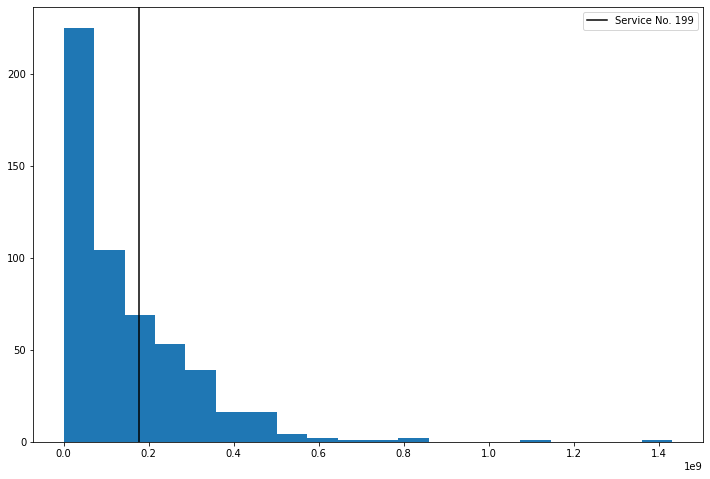

In [168]:
temp_bus = '199'
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist([i['ttt_contribution'] for i in bus_ttt_contributions.values()], axes=ax, bins=20)
plt.axvline(bus_ttt_contributions[temp_bus]['ttt_contribution'], label=f"Service No. {temp_bus}", color='black')
plt.legend()
plt.show()

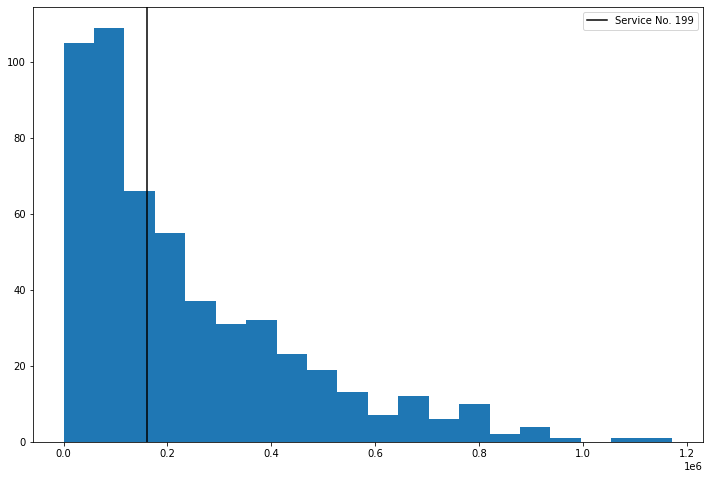

In [169]:
temp_bus = '199'
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist([i['trips_influenced'] for i in bus_ttt_contributions.values()], axes=ax, bins=20)
plt.axvline(bus_ttt_contributions[temp_bus]['trips_influenced'], label=f"Service No. {temp_bus}", color='black')
plt.legend()
plt.show()

# Distance normalized TTT

In [170]:
bus_ttt.head()

,orig,dest,freq_type,avg_trips,best_buses,best_parallelized_time,all_candidates,ttt_contribution
0,1012,1112,AM_Offpeak_Freq,760.428571,"{7, 12, 80, 12e, 63, 175}",86.505551,"{'12': {'travel': 90.0, 'wait': 345.0, 'total'...",65781.292217
1,1012,1112,AM_Peak_Freq,126.142857,"{7, 12, 80, 12e, 63, 175}",70.070728,"{'12': {'travel': 90.0, 'wait': 300.0, 'total'...",8838.921774
2,1012,1112,PM_Offpeak_Freq,175.285714,"{7, 12, 80, 12e, 63, 175}",93.051703,"{'12': {'travel': 90.0, 'wait': 360.0, 'total'...",16310.634185
3,1012,1112,PM_Peak_Freq,245.857143,"{7, 12, 80, 12e, 63, 175}",83.038050,"{'12': {'travel': 90.0, 'wait': 330.0, 'total'...",20415.497656
4,1012,1113,AM_Offpeak_Freq,438.142857,"{2, 2A, 61, 51, 33, 32}",88.426798,"{'2': {'travel': 108.0000000000001, 'wait': 39...",38743.569743


In [171]:
# since we assume avg speed to be constant = 20kmph = 50/9 m/s, we can get average distance between stops from the all_candidates section
# getting avg distance in meters
bus_ttt['dist_m'] = bus_ttt.apply(lambda x: custom_mean([i['travel']*50/9 for i in x['all_candidates'].values()]), axis=1)
bus_ttt.head()

,orig,dest,freq_type,avg_trips,best_buses,best_parallelized_time,all_candidates,ttt_contribution,dist_m
0,1012,1112,AM_Offpeak_Freq,760.428571,"{7, 12, 80, 12e, 63, 175}",86.505551,"{'12': {'travel': 90.0, 'wait': 345.0, 'total'...",65781.292217,500.0
1,1012,1112,AM_Peak_Freq,126.142857,"{7, 12, 80, 12e, 63, 175}",70.070728,"{'12': {'travel': 90.0, 'wait': 300.0, 'total'...",8838.921774,500.0
2,1012,1112,PM_Offpeak_Freq,175.285714,"{7, 12, 80, 12e, 63, 175}",93.051703,"{'12': {'travel': 90.0, 'wait': 360.0, 'total'...",16310.634185,500.0
3,1012,1112,PM_Peak_Freq,245.857143,"{7, 12, 80, 12e, 63, 175}",83.038050,"{'12': {'travel': 90.0, 'wait': 330.0, 'total'...",20415.497656,500.0
4,1012,1113,AM_Offpeak_Freq,438.142857,"{2, 2A, 61, 51, 33, 32}",88.426798,"{'2': {'travel': 108.0000000000001, 'wait': 39...",38743.569743,600.0


(array([7.39640e+05, 1.98125e+05, 4.13050e+04, 1.71990e+04, 7.12200e+03,
        3.11300e+03, 8.42000e+02, 4.84000e+02, 2.80000e+01, 3.70000e+01]),
 array([5.55555556e+01, 1.48377778e+04, 2.96200000e+04, 4.44022222e+04,
        5.91844444e+04, 7.39666667e+04, 8.87488889e+04, 1.03531111e+05,
        1.18313333e+05, 1.33095556e+05, 1.47877778e+05]),
 <BarContainer object of 10 artists>)

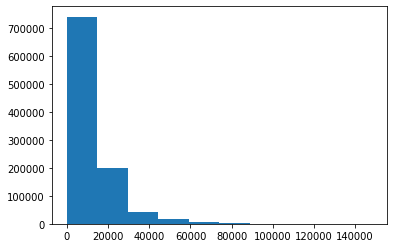

In [173]:
plt.hist(bus_ttt['dist_m'])

In [174]:
bus_ttt['ttt_pm'] = bus_ttt.apply(lambda x: x['ttt_contribution']/x['dist_m'], axis=1)
bus_ttt.head()

,orig,dest,freq_type,avg_trips,best_buses,best_parallelized_time,all_candidates,ttt_contribution,dist_m,ttt_pm
0,1012,1112,AM_Offpeak_Freq,760.428571,"{7, 12, 80, 12e, 63, 175}",86.505551,"{'12': {'travel': 90.0, 'wait': 345.0, 'total'...",65781.292217,500.0,131.562584
1,1012,1112,AM_Peak_Freq,126.142857,"{7, 12, 80, 12e, 63, 175}",70.070728,"{'12': {'travel': 90.0, 'wait': 300.0, 'total'...",8838.921774,500.0,17.677844
2,1012,1112,PM_Offpeak_Freq,175.285714,"{7, 12, 80, 12e, 63, 175}",93.051703,"{'12': {'travel': 90.0, 'wait': 360.0, 'total'...",16310.634185,500.0,32.621268
3,1012,1112,PM_Peak_Freq,245.857143,"{7, 12, 80, 12e, 63, 175}",83.038050,"{'12': {'travel': 90.0, 'wait': 330.0, 'total'...",20415.497656,500.0,40.830995
4,1012,1113,AM_Offpeak_Freq,438.142857,"{2, 2A, 61, 51, 33, 32}",88.426798,"{'2': {'travel': 108.0000000000001, 'wait': 39...",38743.569743,600.0,64.572616


In [175]:
bus_ttt_contributions = {k:{'ttt_contribution':0, 'ttt_pm':0, 'num_routes':0, 'trips_influenced':0} for k in bus_dist_dict.keys()}
for row in bus_ttt.itertuples():
    for k in row.best_buses:
        bus_ttt_contributions[k]['ttt_contribution'] += row.ttt_contribution
        bus_ttt_contributions[k]['ttt_pm'] += row.ttt_pm
        bus_ttt_contributions[k]['num_routes'] += 1
        bus_ttt_contributions[k]['trips_influenced'] += row.avg_trips


In [176]:
sorted(bus_ttt_contributions.items(), key=lambda x: x[1]['ttt_pm'], reverse=True)[:10]

[('88',
  {'ttt_contribution': 578014101.0809077,
   'ttt_pm': 146764.4689567026,
   'num_routes': 8787,
   'trips_influenced': 896506.7142857127}),
 ('147',
  {'ttt_contribution': 515094475.23209965,
   'ttt_pm': 134806.87848706983,
   'num_routes': 15666,
   'trips_influenced': 1171727.0000000093}),
 ('67',
  {'ttt_contribution': 577447778.1033592,
   'ttt_pm': 124138.42212833492,
   'num_routes': 18818,
   'trips_influenced': 1108216.8571428533}),
 ('72',
  {'ttt_contribution': 743479576.9055507,
   'ttt_pm': 121856.83967102526,
   'num_routes': 5640,
   'trips_influenced': 600987.2857142803}),
 ('50',
  {'ttt_contribution': 382630899.87621236,
   'ttt_pm': 120765.90205079176,
   'num_routes': 7910,
   'trips_influenced': 481887.2857142839}),
 ('145',
  {'ttt_contribution': 411035966.942749,
   'ttt_pm': 120466.83358780823,
   'num_routes': 8019,
   'trips_influenced': 677625.4285714242}),
 ('65',
  {'ttt_contribution': 450752511.92223454,
   'ttt_pm': 117366.81985516597,
   'num_ro

In [177]:
bus_ttt_contributions['199']

{'ttt_contribution': 177657399.8110185,
 'ttt_pm': 28048.834697121954,
 'num_routes': 1043,
 'trips_influenced': 161594.85714285725}

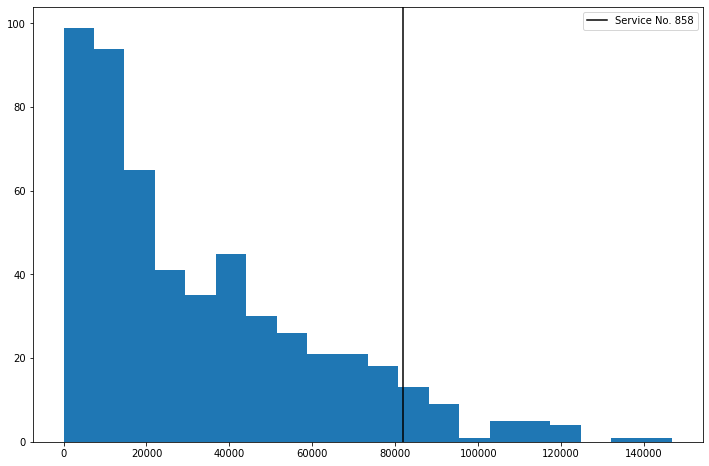

In [179]:
temp_bus = '858'
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist([i['ttt_pm'] for i in bus_ttt_contributions.values()], axes=ax, bins=20)
plt.axvline(bus_ttt_contributions[temp_bus]['ttt_pm'], label=f"Service No. {temp_bus}", color='black')
plt.legend()
plt.show()

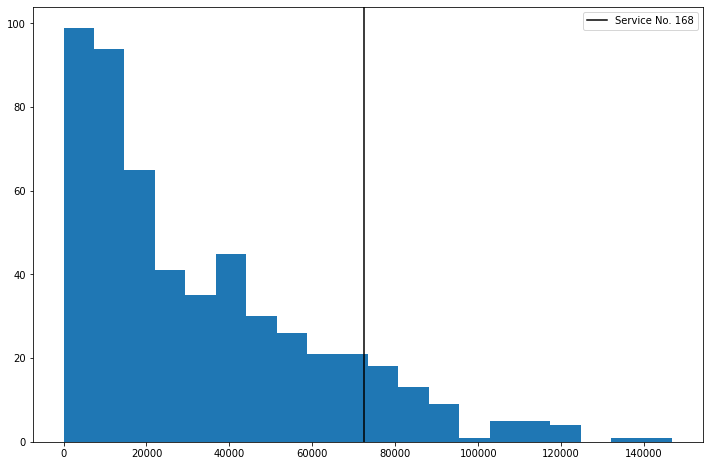

In [180]:
temp_bus = '168'
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist([i['ttt_pm'] for i in bus_ttt_contributions.values()], axes=ax, bins=20)
plt.axvline(bus_ttt_contributions[temp_bus]['ttt_pm'], label=f"Service No. {temp_bus}", color='black')
plt.legend()
plt.show()

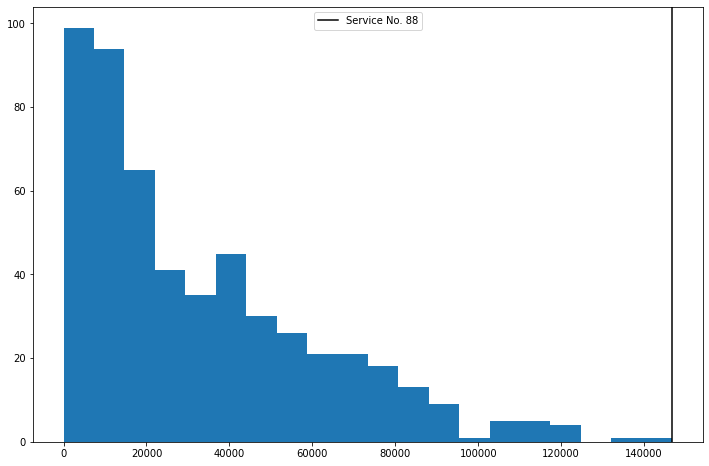

In [181]:
temp_bus = '88'
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist([i['ttt_pm'] for i in bus_ttt_contributions.values()], axes=ax, bins=20)
plt.axvline(bus_ttt_contributions[temp_bus]['ttt_pm'], label=f"Service No. {temp_bus}", color='black')
plt.legend()
plt.show()

In [202]:
def plot_hist_percentiles_bus(busno, metrics=['ttt_contribution', 'ttt_pm', 'num_routes', 'trips_influenced'], bus_ttt_contributions=bus_ttt_contributions):
    fig, ax = plt.subplots(len(metrics), figsize=(12, 8))
    for i, metric in enumerate(metrics):
        full_list = sorted([v[metric] for v in bus_ttt_contributions.values()], reverse=True)
        pos = full_list.index(bus_ttt_contributions[busno][metric])
        perc = round((1 - pos/len(full_list))*100, 2)
        ax[i].hist([i[metric] for i in bus_ttt_contributions.values()], bins=20)
        ax[i].axvline(bus_ttt_contributions[busno][metric], color='black')
        ax[i].set_title(f"Ranked #{pos+1} for {metric} - {perc}%ile")
    fig.tight_layout()
    return fig

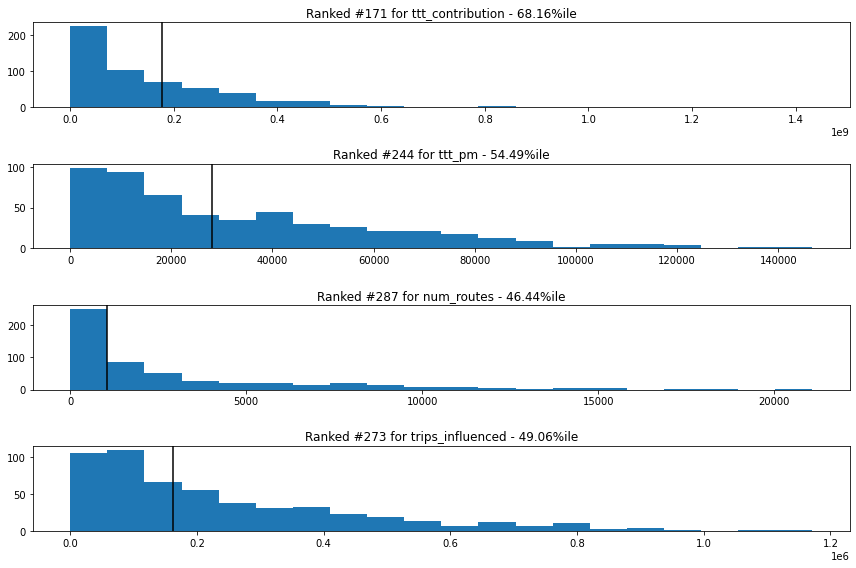

In [203]:
fig = plot_hist_percentiles_bus('199')
plt.show()

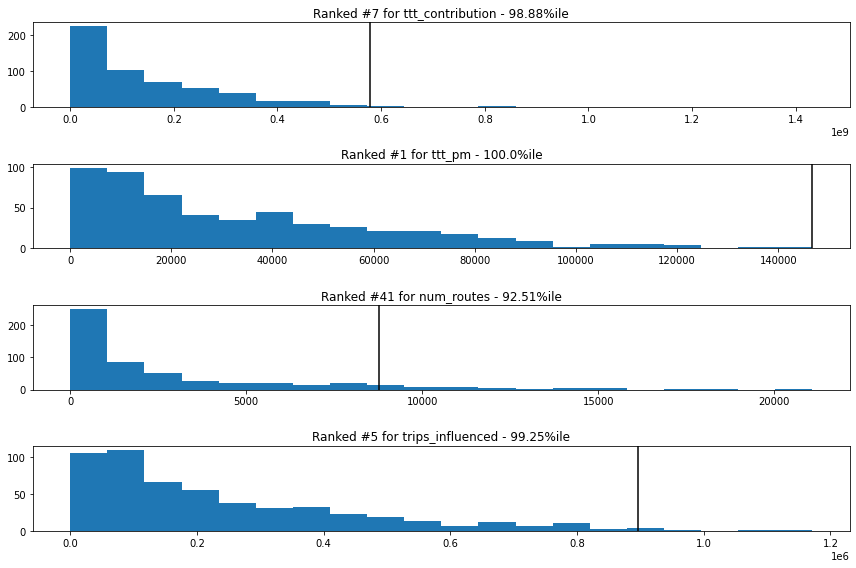

In [204]:
fig = plot_hist_percentiles_bus('88')
plt.show()

In [208]:
with open('results/bus_ttt_contributions.json', 'w') as fileobj:
    json.dump(bus_ttt_contributions, fileobj, indent=2)